# SCANIA Trucks APS Failure Prediction

# 1. Introduction

Air Pressure System (APS) in trucks generates pressurized air that is used for various functions
of trucks such as braking and gear changes. Lot of money is spent on un-necessary checks done
by service person on APS system in trucks, which can be prevented by developing a machine
learning model that can predict the failure of component in APS. In this way, service can be
restricted to the trucks whose APS component is predicted to be failed by the model.

The given dataset positive class consists of component failures for a specific component of the
APS system. The negative class consists of trucks with failures for components not related to the
APS. Attributes of dataset are anonymized for proprietary reasons. This is a binary classification
problem.

### Challenge metric

Cost-metric of miss-classification:

Given, Cost_1 = 10 and cost_2 = 500
The total cost of a prediction model the sum of 'Cost_1'
multiplied by the number of Instances with type 1 failure
and 'Cost_2' with the number of instances with type 2 failure,
resulting in a 'Total_cost'.

In this case Cost_1 refers to the cost that an unnessecary
check needs to be done by an mechanic at an workshop, while
Cost_2 refer to the cost of missing a faulty truck,
which may cause a breakdown.

#### Total_cost = Cost_1 times No_Instances with type 1 + Cost_2 times No_Instances with type2.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import re
import os
import datetime as dt
import pickle
from datetime import datetime
from scipy import stats
import random
from sklearn.model_selection import KFold
from IPython.display import display, Markdown
import pickle
from pandas import Series
from collections import defaultdict
import math
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import f1_score, auc, accuracy_score, recall_score, precision_score,\
confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


# 2. Exploratory Data Analysis

## 2.1 Train Dataset

In [2]:
#Read train data
train = pd.read_csv('aps_failure_training_set.csv')
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


Observation: There are 171 features in train data,among which few are histogram features

In [4]:
train['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

### Count Plot

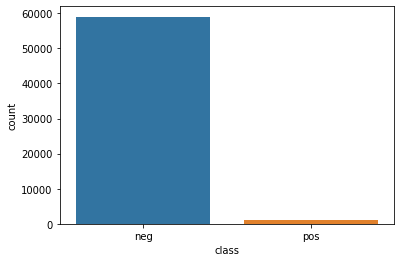

In [42]:
#Countplot
sns.countplot(x="class", data=train)
plt.show()

Observation: From the above plot it can be observed that the give training data is highly imbalanced,negative class dominates positive

In [3]:
# Replacing the na and nan values with np.NaN
train.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [44]:
# Number of missing values in each column
train.isnull().sum(axis = 0)

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64

### Total Missing Count and its Percentage

In [45]:
#Reference: https://www.kaggle.com/pavansanagapati/a-simple-tutorial-on-exploratory-data-analysis
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Total Missing Count in the column', '% of Total Observations in the column'])
missing_data.index.name ='Feature'

missing_data.head(10)

,Total Missing Count in the column,% of Total Observations in the column
Feature,,
br_000,49264,82.106667
bq_000,48722,81.203333
bp_000,47740,79.566667
bo_000,46333,77.221667
cr_000,46329,77.215000
ab_000,46329,77.215000
bn_000,44009,73.348333
bm_000,39549,65.915000
bl_000,27277,45.461667


Observation: Above table shows top 10 features as per the missing values. Percentage of missing data in corresponding colum is also shown

### Bar Chart representation of data

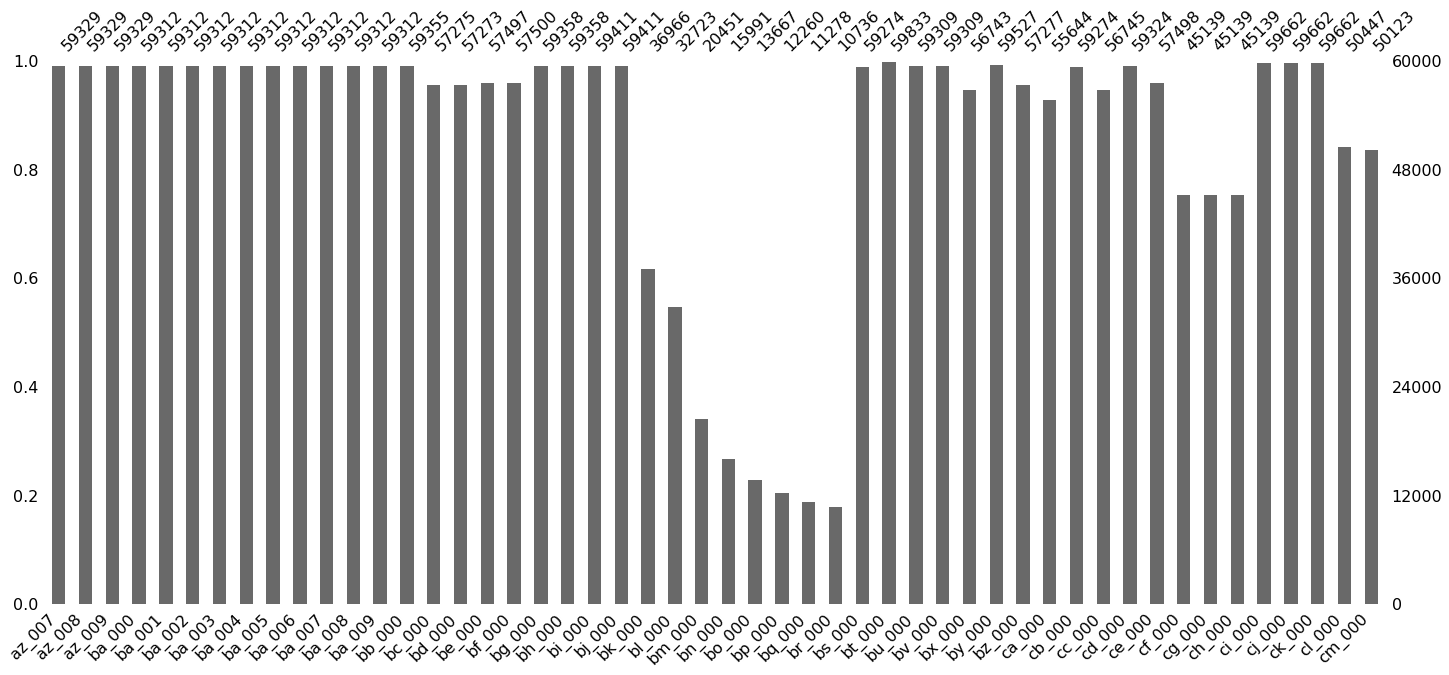

In [46]:
# Plot to indicate the completeness of few columns in dataset.
# Reference: https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/
column_names= train.columns
msno.bar(train[column_names[50:100]])

Observation: The above charts shows the completeness of data in columns 100 to 150

In [72]:
#Seperating label column from the data
y_train = train['class']
train.drop(['class'],axis = 1,inplace = True)

### Probability Plot

((array([-4.23255856, -4.02871318, -3.91765076, ...,  3.91765076,
          4.02871318,  4.23255856]),
  array([ 0.       ,  0.       ,  0.       , ..., 14.6557523, 14.7053378,
         14.8258616])),
 (3.029836247901517, 8.646472449040342, 0.9383635216575297))

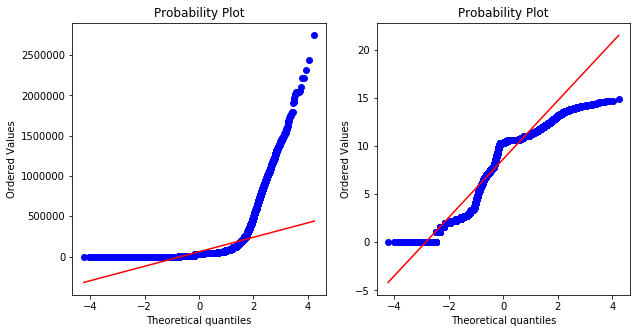

In [49]:
#Reference - https://www.kaggle.com/viveksrinivasan/eda-focus-on-missing-values-and-simple-xgb
#https://www.itl.nist.gov/div898/handbook/eda/section3/normprpl.htm
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(10, 5)
stats.probplot(train["aa_000"], dist='norm', fit=True, plot=axes[0])
stats.probplot(np.log1p(train["aa_000"]), dist='norm', fit=True, plot=axes[1])

Observation: The above probability plot shows that feature aa_000 does not follow normal distribution

In [59]:
#Imputing the missing data with mean values for further analysis
impute_mean = SimpleImputer(missing_values= np.nan, strategy='mean',copy = True, verbose= 2)
train_mean_imputed = pd.DataFrame(impute_mean.fit_transform(train),columns=train.columns)


### Pair Plot 

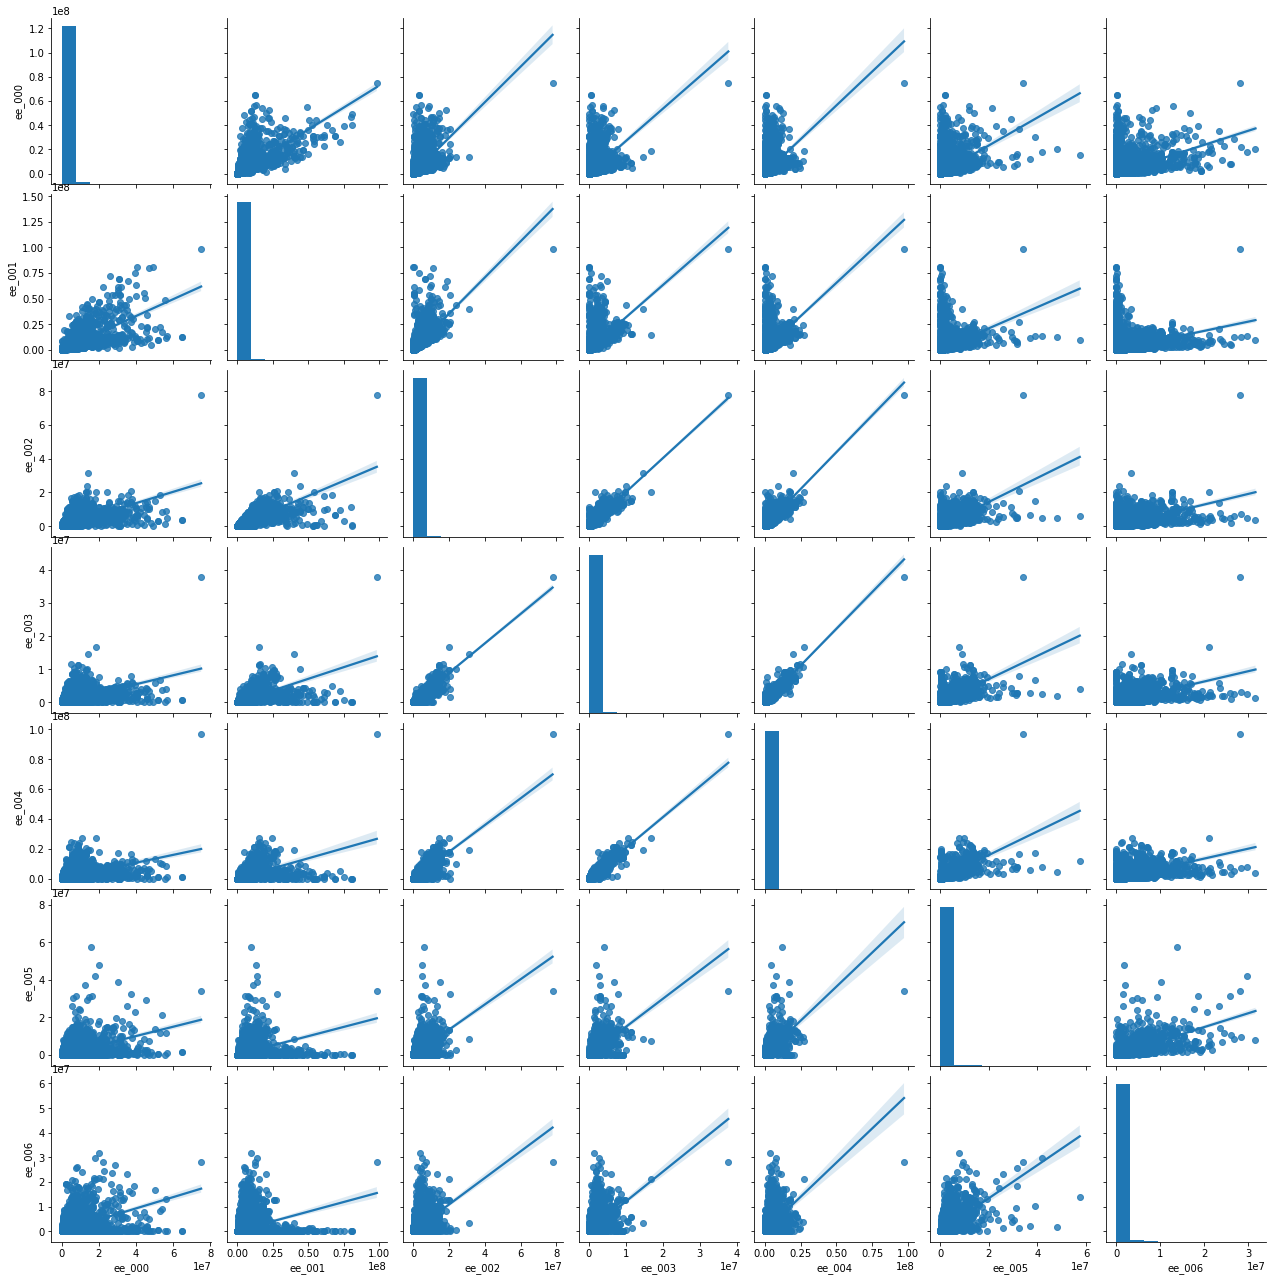

In [38]:
# Pair Plot of Histogram feature ee
g = sns.pairplot(train_mean_imputed, vars=['ee_000', "ee_001", "ee_002", 'ee_003', 'ee_004', 'ee_005', 'ee_006'], kind="reg")

Observation: Histogram variable ee is taken for analysis. Pair plot shows that ee_003 and ee_004 are highly correlated and have positive correlation. Relation among other features can also be observed.

### Heat map of correlation among features

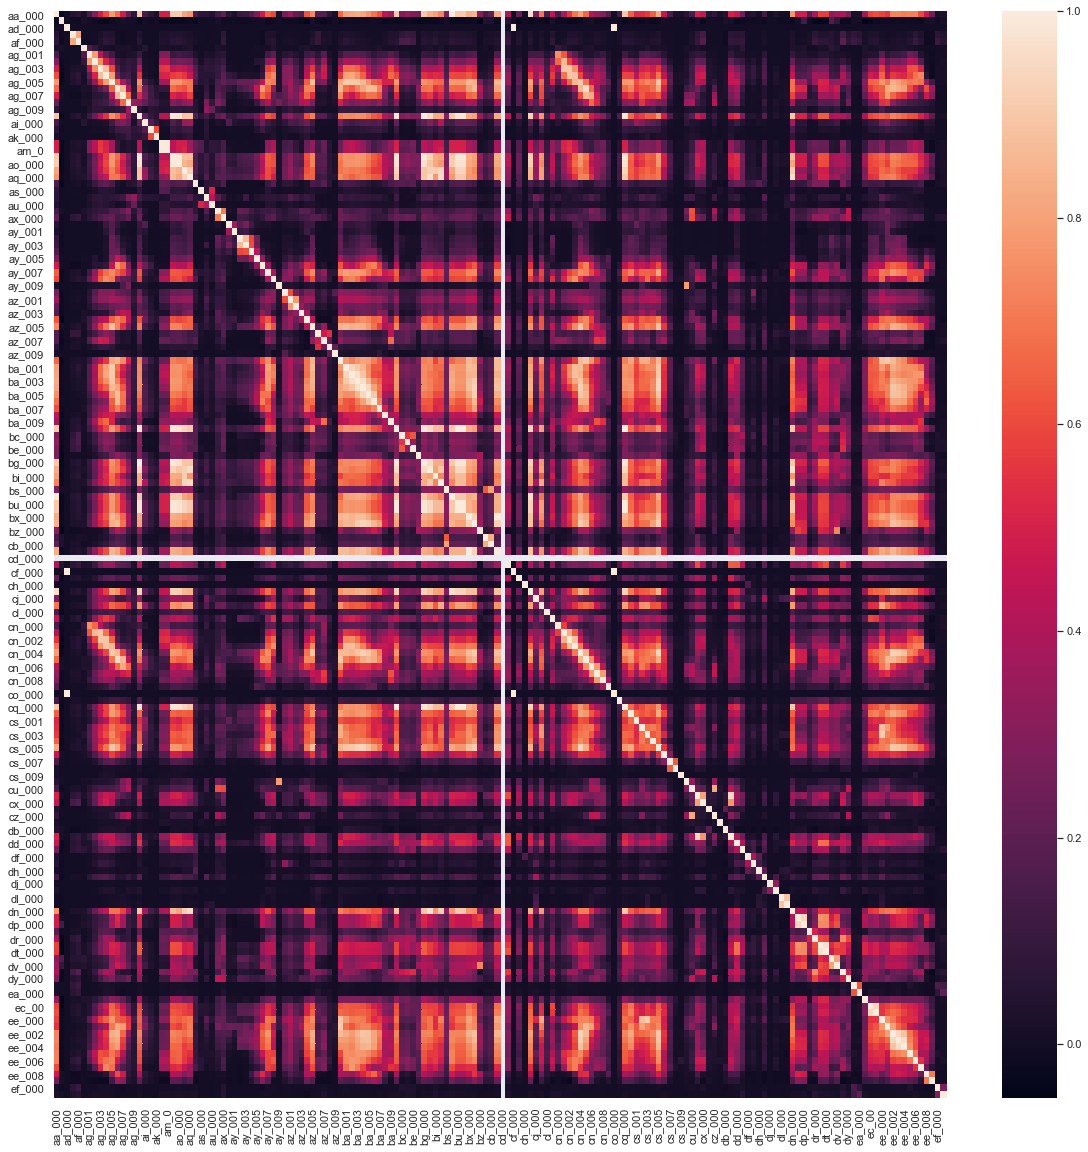

In [25]:
#Plotting heat map for feature correlation from correlation matrix
corr_matrix = train_mean_imputed.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr_matrix, annot=False)
plt.show()

Observation: The above plot shows the degree of correlation among features

### Box Plot

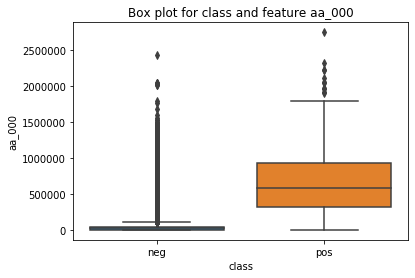

In [19]:
#Box Plot for aa_000 feature
sns.boxplot(x='class',y='aa_000', data=train).set_title("Box plot for class and feature aa_000")
plt.show()

Observation: Shown plot only for aa_000 feature. Max, min values, outliers of both positive and negative class can be observed from above plot. Plot shows that negative class has more outliers and positive class is dominating when compared to negative. 

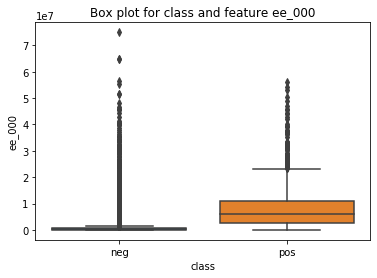

In [14]:
#Box Plot for histogram feature ee_000 
train_plot= train[['class', 'ee_000']]
# Removing rows with missing values
train_plot = train_plot.dropna(axis =0)
train_plot['ee_000'] = train_plot['ee_000'].astype(float)
sns.boxplot(x='class',y='ee_000', data=train_plot).set_title("Box plot for class and feature ee_000")
plt.show()

Observation: Above plot shows box plot for histogram feature ee_000. Max, min values, outliers of both positive and negative class can be observed from above plot. Plot shows that negative class has more outliers and positive class is dominating when compared to negative. 

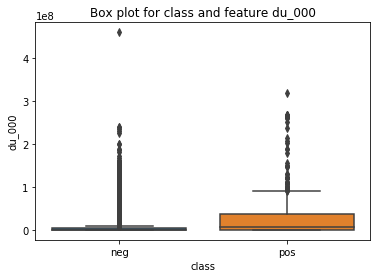

In [17]:
#Box Plot for du_000 feature
train_plot= train[['class', 'du_000']]
# Removing rows with missing values
train_plot = train_plot.dropna(axis =0)
train_plot['du_000'] = train_plot['du_000'].astype(float)
sns.boxplot(x='class',y='du_000', data=train_plot).set_title("Box plot for class and feature du_000")
plt.show()

Observation: Above plot shows box plot for du_000 feature. Plot shows that there is no highly dominating class, both the classes have outliers.

### Histogram

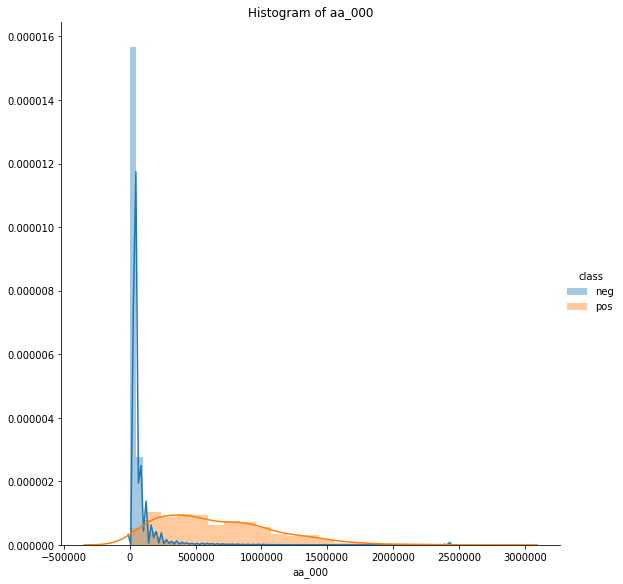

In [20]:
#Histogram of aa_000 feature
sns.FacetGrid(train, hue="class", size=8).map(sns.distplot, "aa_000").add_legend()
plt.title("Histogram of aa_000")
plt.show()

Observation: Plot shows the distribution of positive and negative classes. Spread of positive class is more than negative, and values of positive class are below 0 as well. Positive class has long ending tail compared to negative class. Negative class has peak more than positive class.

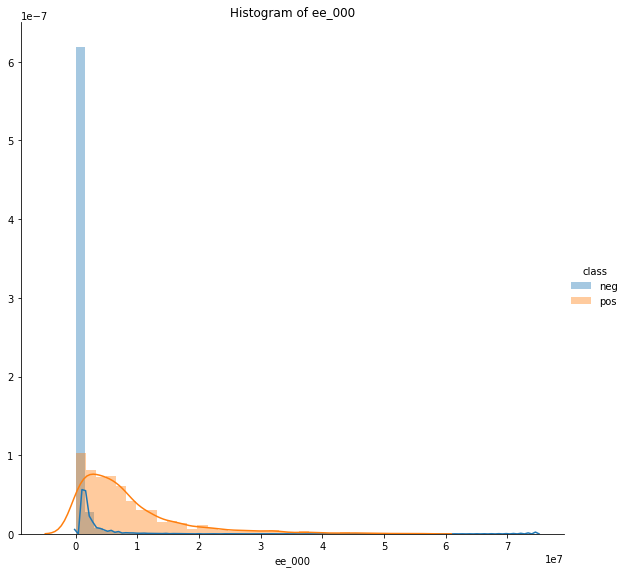

In [15]:
#Histogram of feature ee_000
sns.FacetGrid(train_plot, hue="class", size=8).map(sns.distplot, "ee_000").add_legend()
plt.title("Histogram of ee_000")
plt.show()

Observation: Plot shows the distribution of positive and negative classes. Spread of positive class is more than negative, and values of positive class are below 0 as well. Positive class has long ending tail compared to negative class. positive class has peak more than negative class.

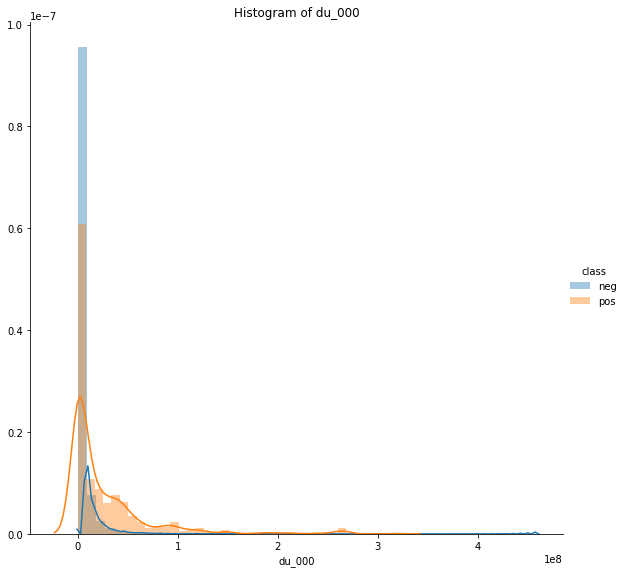

In [18]:
#Histogram of du_000 feature
sns.FacetGrid(train_plot, hue="class", size=8).map(sns.distplot, "du_000").add_legend()
plt.title("Histogram of du_000")
plt.show()

Observation: Plot shows the distribution of positive and negative classes. Spread of positive class is more than negative, and values of positive class are below 0 as well. Positive class has long ending tail compared to negative class. Positive class has peak more than negative class.

## 2.2 Test Dataset

In [10]:
#Read test data
test = pd.read_csv("aps_failure_test_set.csv")
test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


In [11]:
test['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

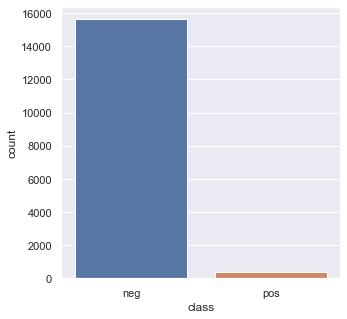

In [12]:
#Countplot
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x="class", data=test)
plt.show()

Observation: From the above plot it can be observed that the give test data is highly imbalanced,negative class dominates positive

In [13]:
test.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [14]:
test.isnull().sum(axis = 0)

class         0
aa_000        0
ab_000    12363
ac_000      926
ad_000     3981
          ...  
ee_007      192
ee_008      192
ee_009      192
ef_000      762
eg_000      762
Length: 171, dtype: int64

Observation: Number of missing values in each column is shown